In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import model_zoo

__all__ = ['GoogLeNet', 'googlenet']

model_urls = {
    # GoogLeNet ported from TensorFlow
    'googlenet': 'https://download.pytorch.org/models/googlenet-1378be20.pth',
}


def googlenet(pretrained=False, **kwargs):
    r"""GoogLeNet (Inception v1) model architecture from
    `"Going Deeper with Convolutions" <http://arxiv.org/abs/1409.4842>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        if 'transform_input' not in kwargs:
            kwargs['transform_input'] = True
        kwargs['init_weights'] = False
        model = GoogLeNet(**kwargs)
        model.load_state_dict(model_zoo.load_url(model_urls['googlenet']))
        return model

    return GoogLeNet(**kwargs)


class GoogLeNet(nn.Module):

    def __init__(self, num_classes=1000, aux_logits=True, transform_input=False, init_weights=True):
        super(GoogLeNet, self).__init__()
        self.aux_logits = aux_logits
        self.transform_input = transform_input

        self.conv1 = BasicConv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        self.conv2 = BasicConv2d(64, 64, kernel_size=1)
        self.conv3 = BasicConv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception(512, 160, 112, 224, 24, 64, 64, final=True)
        self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.inception5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception(832, 384, 192, 384, 48, 128, 128)
        if aux_logits:
            self.aux1 = InceptionAux(512, num_classes)
            self.aux2 = InceptionAux(528, num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)

        if init_weights:
            self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.2)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        if self.transform_input:
            x_ch0 = torch.unsqueeze(x[:, 0], 1) * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x_ch1 = torch.unsqueeze(x[:, 1], 1) * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x_ch2 = torch.unsqueeze(x[:, 2], 1) * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
            x = torch.cat((x_ch0, x_ch1, x_ch2), 1)

        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.maxpool2(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)
        x = self.inception4a(x)
        if self.training and self.aux_logits:
            aux1 = self.aux1(x)

        x = self.inception4b(x)
        return x
        x = self.inception4c(x)
        x = self.inception4d(x)
        if self.training and self.aux_logits:
            aux2 = self.aux2(x)

        x = self.inception4e(x)
        x = self.maxpool4(x)
        x = self.inception5a(x)
        x = self.inception5b(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        if self.training and self.aux_logits:
            return aux1, aux2, x
        return x


class Inception(nn.Module):

    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj, final=False):
        super(Inception, self).__init__()

        self.branch1 = BasicConv2d(in_channels, ch1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            BasicConv2d(in_channels, ch3x3red, kernel_size=1),
            BasicConv2d(ch3x3red, ch3x3, kernel_size=3, padding=1)
        )

        self.branch3 = nn.Sequential(
            BasicConv2d(in_channels, ch5x5red, kernel_size=1),
            BasicConv2d(ch5x5red, ch5x5, kernel_size=3, padding=1)
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1, ceil_mode=True),
            BasicConv2d(in_channels, pool_proj, kernel_size=1, final=final)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        outputs = [branch1, branch2, branch3, branch4]
        return torch.cat(outputs, 1)


class InceptionAux(nn.Module):

    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()
        self.conv = BasicConv2d(in_channels, 128, kernel_size=1)

        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = F.adaptive_avg_pool2d(x, (4, 4))

        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x), inplace=True)
        x = F.dropout(x, 0.7, training=self.training)
        x = self.fc2(x)

        return x


class BasicConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, final=False, **kwargs):
        super(BasicConv2d, self).__init__()
        self.final = final
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        if self.final:
            return x
        x = self.bn(x)
        return F.relu(x, inplace=True)

In [3]:
size = [224, 224]
size = [128, 128]

In [5]:
from dreamz.cppn import get_xy_mesh, CPPNNet, UpsampleNet

device = 'cuda'
widths = [24] * 8
viz = CPPNNet(widths, input_channels=3)
viz = UpsampleNet(viz, reps=1)
viz = viz.to(device)
# viz = nn.DataParallel(viz)

/home/liam/.virtualenvs/py36/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/liam/.virtualenvs/py36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


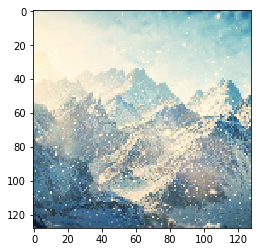

In [6]:
from skimage.transform import resize
target_im = plt.imread('/home/liam/wallpapers/40 - H6RH3ke.jpg') / 255
# target_im = plt.imread('/home/liam/wallpapers/82 - 0ESdadG.jpg') / 255
target_im = resize(target_im[:, 420:-420], size)
plt.imshow(target_im)
target_im = torch.FloatTensor(target_im)
target_im = target_im.permute(2, 0, 1).unsqueeze(0).cuda()

In [7]:
# device = 'cuda'
# mean = torch.FloatTensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
# std = torch.FloatTensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)
# r = imagenet_model((target_im - mean) / std)

In [8]:
import time
from skimage.io import imsave
from dreamz.utils import get_latest_filename, tch_im_to_np
from dreamz.render import train_visualiser
from dreamz.torch_utils import Lambda, adjust_learning_rate
from dreamz.cppn import composite_activation
import torch
from torch import nn
from torchvision import models
from torch.nn import functional as F
from torch import optim
import numpy as np

def train(size, widths, imagenet_model, chan_to_opt, log_interval, batch_size = 32):
    mean = torch.FloatTensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
    std = torch.FloatTensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)
    
    with torch.no_grad():
        target = imagenet_model((target_im - mean) / std)
    def get_alphas(batch_size, device):
#         alphas = torch.linspace(-1, 0.9, batch_size) + torch.rand(size=[batch_size]) * 0.1
        alphas = torch.randn(size=[batch_size])
        alphas = alphas.to(device)
        return alphas

    def mse_loss_fn(ims, alphas, distance_constant=0.2):
        # I think this loss is just trying to make different parts of the image have diff features
        ims = ims.view(ims.shape[0], -1)
        actual_distances = torch.abs(ims.unsqueeze(0) - ims.unsqueeze(0).permute(1, 0, 2)).mean(2)
        return -torch.mean(actual_distances)
#         targ_distances = distance_constant * torch.abs(alphas.unsqueeze(0) - alphas.unsqueeze(1))
#         return torch.mean(actual_distances - targ_distances)
    
    def imgnet_objective(output, alphas):
        r = imagenet_model((output - mean) / std)
        loss = ((r - target) ** 2).mean()
    #     return torch.mean((r - targ) ** 2)
#         loss = -r[:, chan_to_opt].mean()
#         mse_loss = mse_loss_fn(output, alphas)
#         loss = loss + mse_loss * 0
        return loss

    xy = get_xy_mesh(size).to(device)
    xy = xy.repeat([batch_size, 1, 1, 1])

    def im_gen_fn(pct_done=0.0):
        alphas = get_alphas(batch_size, device)
        inp = torch.cat([xy, alphas.view(-1, 1, 1, 1).repeat([1, 1, *xy.shape[-2:]])], 1)
        return viz(inp), alphas

    opt = optim.Adam(viz.parameters(), lr=0.002)
    adj = lambda opt: adjust_learning_rate(opt, 0.1)
    train_visualiser(imgnet_objective, im_gen_fn, opt, iters=101,
                     log_interval=log_interval, sched=[(3100, adj)])
    return viz

def get_imagenet_model():
    model = googlenet(pretrained=True)
    return model.eval()

imagenet_model = get_imagenet_model()

In [9]:
imagenet_model = imagenet_model.to(device)
imagenet_model = nn.DataParallel(imagenet_model)

In [10]:
def printt():
    print(imagenet_model(torch.ones(size=[1, 3, 224, 224])).shape)
printt()

torch.Size([1, 512, 14, 14])


In [ ]:
chan_to_opt = 2

log_interval = 50

now = time.time()
print('Training {}'.format(chan_to_opt))
viz = train(size, widths, imagenet_model, chan_to_opt, log_interval, batch_size=16)
print('Took {} seconds'.format(time.time() - now))
now = time.time()

In [27]:
torch.save(viz.module.state_dict(), '/home/liam/dreamz/data/state_dicts_v2/0000.pth')

In [17]:
from dreamz.utils import tch_im_to_pil
ims_savedir = '../data/output_ims3/'
bigsize = [1080//2, 1080//2]
def big_save_fn(alpha = 0.0):
    xy_big = get_xy_mesh(bigsize).to(device)
#     xy_big = get_xy_mesh([1080, 1920]).to(device)
    alpha = torch.FloatTensor([alpha]).to(device).view(1, 1, 1, 1).repeat([1, 1, *xy_big.shape[-2:]])
    res = viz(torch.cat([xy_big, alpha], 1))
#     imsave(get_latest_filename(ims_savedir), tch_im_to_np(res))
    return (tch_im_to_np(res))

In [18]:
import numpy as np
from PIL import Image, ImageDraw
import cv2
from tqdm import tqdm

fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
video = cv2.VideoWriter('test.mp4', fourcc, 60, (540, 540))
for alpha in (np.linspace(-2, 2, 400)):
    im_np = big_save_fn(alpha)
    video.write(cv2.cvtColor(im_np, cv2.COLOR_RGB2BGR))
video.release()